In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import lasso_path
from sklearn.model_selection import train_test_split

In [7]:
#  Keep only the observations with no missing values: 0.25 points

# Ruta al archivo Excel
xlsx_path = r"..\input\Districtwise_literacy_rates.xlsx"

# Leer el archivo Excel
df = pd.read_excel(xlsx_path).dropna()

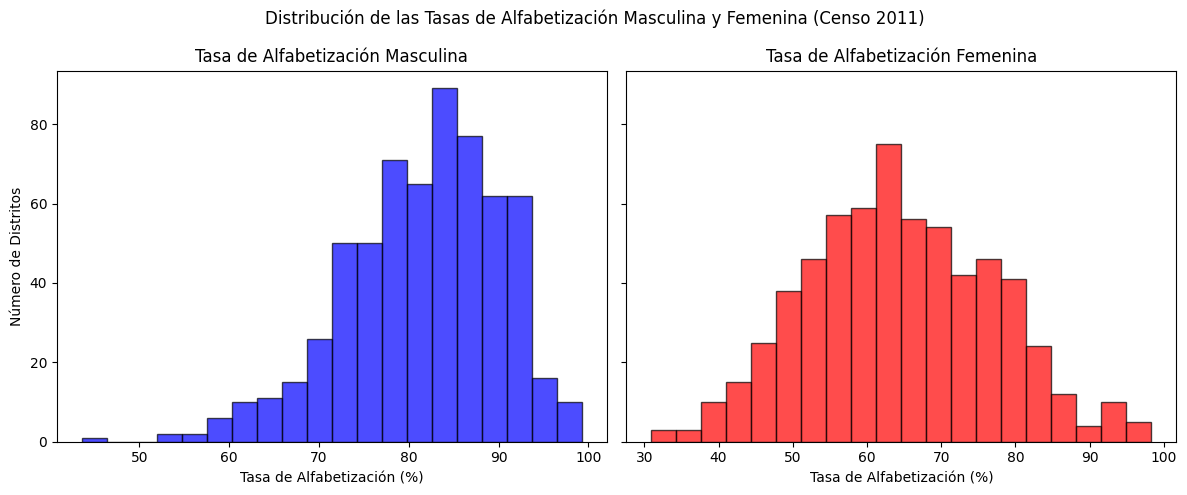

In [9]:
#2)
# Identificar nombres de columnas
male_col = "MALE_LIT"
female_col = "FEMALE_LIT"

# Extraer series
male_lit = df[male_col]
female_lit = df[female_col]

# Graficar
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

axes[0].hist(male_lit, bins=20, color="blue", edgecolor="black", alpha=0.7)
axes[0].set_title("Tasa de Alfabetización Masculina")
axes[0].set_xlabel("Tasa de Alfabetización (%)")
axes[0].set_ylabel("Número de Distritos")

axes[1].hist(female_lit, bins=20, color="red", edgecolor="black", alpha=0.7)
axes[1].set_title("Tasa de Alfabetización Femenina")
axes[1].set_xlabel("Tasa de Alfabetización (%)")

plt.suptitle("Distribución de las Tasas de Alfabetización Masculina y Femenina (Censo 2011)")
plt.tight_layout()
plt.savefig(r"..\output\Histograma.jpg")
plt.show()

In [10]:
y = df["FEMALE_LIT"]

X = df[[
    "TOTPOPULAT",
    "P_URB_POP",
    "SEXRATIO"
]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"R^2 on test set: {r2:.4f}")

R^2 on test set: 0.2249


## 3) Estimate a high-dimensional (flexible)

In [12]:
PRED = ["TOTPOPULAT", "P_URB_POP", "SEXRATIO", "AREA_SQKM", "GROWTHRATE"]

X = df[PRED].to_numpy(dtype=float)
y = df["FEMALE_LIT"].to_numpy(dtype=float)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_tr_poly = poly.fit_transform(X_tr)
X_te_poly = poly.transform(X_te)

scaler = StandardScaler().fit(X_tr_poly)
X_tr_s = scaler.transform(X_tr_poly)
X_te_s = scaler.transform(X_te_poly)

ols = LinearRegression().fit(X_tr_s, y_tr)
y_hat = ols.predict(X_te_s)
r2_high = r2_score(y_te, y_hat)

print(f"Test R^2: {r2_high:.3f}")

Test R^2: 0.223


## 5) For λ ∈ [10,000, 0.001]

In [16]:
from sklearn.linear_model import Lasso

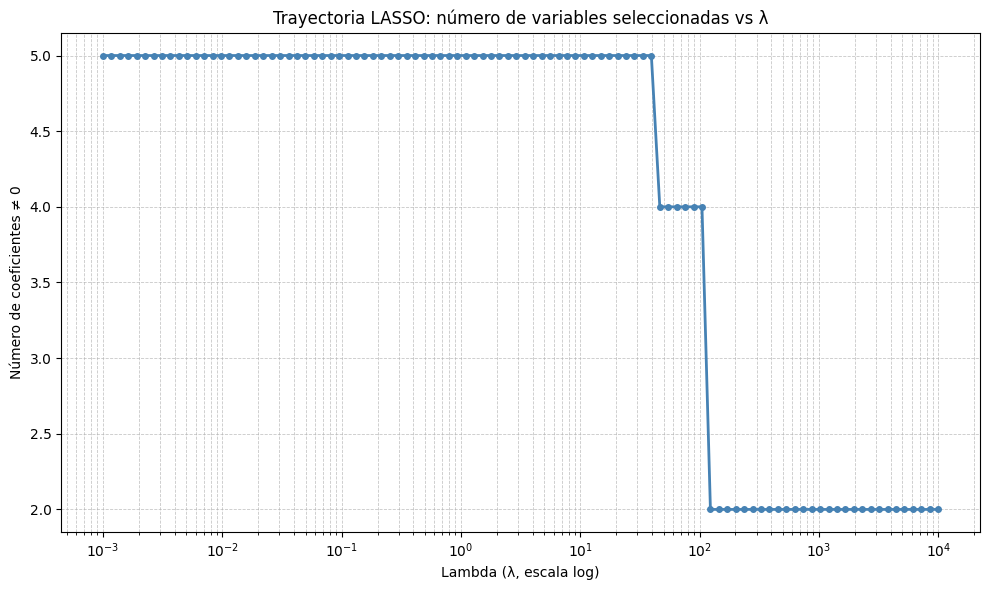

In [26]:
# --- Secuencia de lambdas ---
lambda_seq = np.logspace(np.log10(10000), np.log10(0.001), 100)

nonzero_coefs = []
for lam in lambda_seq:
    lasso = Lasso(alpha=lam, fit_intercept=True, max_iter=10000)
    lasso.fit(X_tr, y_train)
    nz = np.sum(np.abs(lasso.coef_) > 1e-8)
    nonzero_coefs.append(nz)

# --- Crear DataFrame ---
path_data = pd.DataFrame({
    "lambda": lambda_seq,
    "log_lambda": np.log10(lambda_seq),
    "nonzero_coefs": nonzero_coefs
})

# --- Gráfico ---
plt.figure(figsize=(10, 6))
plt.plot(path_data["lambda"], path_data["nonzero_coefs"],
         color="steelblue", linewidth=2, marker="o", markersize=4)
plt.xscale("log")
plt.xlabel("Lambda (λ, escala log)")
plt.ylabel("Número de coeficientes ≠ 0")
plt.title("Trayectoria LASSO: número de variables seleccionadas vs λ")
plt.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.savefig(r"..\output\lasso_path.png", dpi=300)
plt.show()